# Credit Card Fraud Detection
This notebook is dedicated to the study and prediction of credit card fraud from a large transaction dataset.

## Imports and Globals
***
Getting relevant packages for data exploration, processing, and classification. I also read in the transaction csv file and define some colors I will use for my plots throughout this notebook.

In [3]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from IPython.display import HTML

dataset_file = 'data/creditcard.csv'

_red = sns.color_palette('hls')[0]
_blue = sns.color_palette('hls')[4]
cmap = [_blue, _red]
nonfraud_patch = mpatches.Patch(color=_blue, label='Non-Fraud')
fraud_patch = mpatches.Patch(color=_red, label='Fraud')

df = pd.read_csv(dataset_file)

## A look at the data
***
A quick glance at our dataframe shows us that there are 3 known attributes: {Time, Amount, Class}, and 28 unknown attributes: {V1,...,V28}.
- Class Name and Class Dist were added by me to allow for better visualizations later on.

No NULL values is good. In a real scenario, this is unlikely to be the case, but pandas provides plenty of tools for dealing with it.

In [5]:
print('Total number of NULL values:', df.isna().sum().sum())

Total number of NULL values: 0


The unknown attributes were obtained by reducing the dimensions of a larger set of known private attributes. 
- This is done for security purposes. 
- In a production environment, feature engineering would need to be done to select the most important private attributes. 
    - Then a dimensionality reduction technique like PCA could be used if we want a similar dataset.
    - This would not match the data we have here, but we could employ similar EDA techniques to study and classify on the data.

In [6]:
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


The **Time** and **Amount** columns can get fairly large (> 20000). I choose to scale the data to regularize it. 
- StandardScaler and RobustScaler are both good choices, I use StandardScaler.

In [7]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


In [8]:
scaler = StandardScaler()
df[['Time', 'Amount']] = scaler.fit_transform(df[['Time', 'Amount']])

These columns are now normalized, which will definitely improve model performance down the line.

In [9]:
df.describe()[['Time', 'Amount']]

,Time,Amount
count,2.848070e+05,2.848070e+05
mean,-3.065637e-16,2.913952e-17
std,1.000002e+00,1.000002e+00
min,-1.996583e+00,-3.532294e-01
25%,-8.552120e-01,-3.308401e-01
50%,-2.131453e-01,-2.652715e-01
75%,9.372174e-01,-4.471707e-02
max,1.642058e+00,1.023622e+02


#### Data Summary - Class Imbalance
***
This data is highly imbalanced! We have over 280k transaction records of which only 0.17% are fraudulent. 
- We will use techniques to balance the data so that our model can properly fit our dataset. 
    - **Undersampling**
        - Random Undersampling:
        - Tomek Links Unersampling:
    - **Oversampling**
        - Sythetic Minority Oversampling Technique (SMOTE):
        - Borderline SMOTE:

In [10]:
def class_distribution(df):
    fraud = round(len(df.loc[df['Class'] == 1]) / len(df) * 100, 2)
    nonfraud = round(len(df.loc[df['Class'] == 0]) / len(df) * 100, 2)
    print('% dataset with class 0: {}%\n% dataset with class 1: {}%\n'.format(nonfraud, fraud))

In [11]:
print('Size of dataset: {} samples'.format(len(df)))
class_distribution(df)

Size of dataset: 284807 samples
% dataset with class 0: 99.83%
% dataset with class 1: 0.17%



## Exploratory Data Analysis

We start by getting a view of the class imbalance with a simple Count plot. Since over 99% of our data is non-fraudulent transactions, it will be almost impossible for our model to do anything other than trivialize the predictions to the majority class.

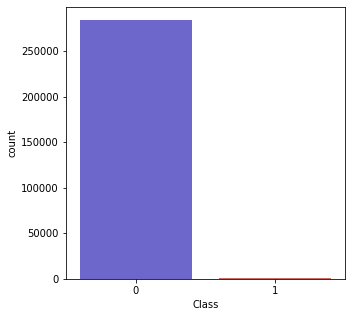

In [12]:
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.countplot(x='Class', data=df, palette=cmap)

#### Amount and Time distributions
***
To get a sense of the only two attributes we actually know, I chose to first just see the overall distribution. 
- Interestingly enough, since the data was collected over a two day period, the day/night cycle is apparent. This is a form of **data drift** that happens because people buy less stuff when they are asleep :)
- This will also be reflected, in a production system, through seasonal buying patterns. Therefore, whatever model we fit may perform worse if the data comes from an entirely different time in the year.

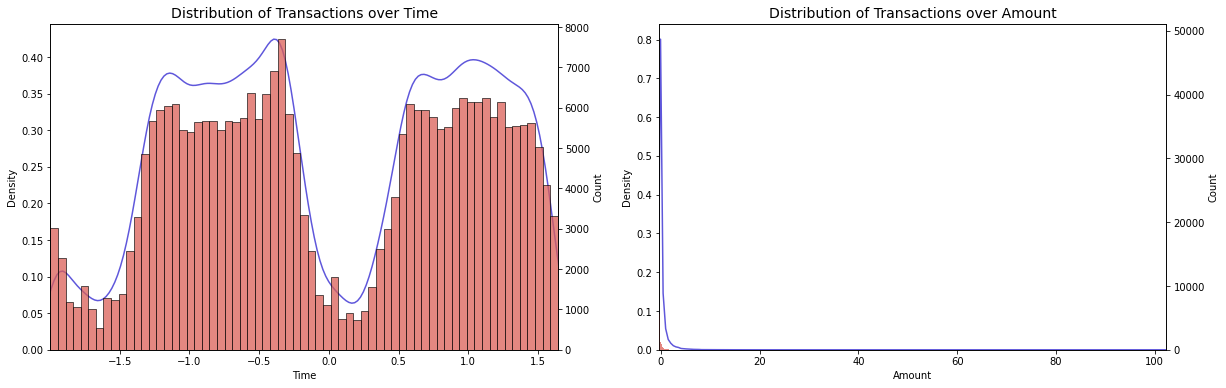

In [13]:
def amount_time_distributions(df):
    _, ax = plt.subplots(1, 2, figsize=(20, 6))
    sns.kdeplot(x='Time', ax=ax[0], data=df, color=cmap[0])
    ax2 = ax[0].twinx()
    sns.histplot(x='Time', ax=ax2, data=df, color=cmap[1])
    ax[0].set_title('Distribution of Transactions over Time', fontsize=14)
    ax[0].set_xlim([min(df['Time']), max(df['Time'])])
    
    sns.kdeplot(x='Amount', ax=ax[1], data=df, color=cmap[0])
    ax2 = ax[1].twinx()
    sns.histplot(x='Amount', ax=ax2, data=df, color=cmap[1])
    ax[1].set_title('Distribution of Transactions over Amount', fontsize=14)
    ax[1].set_xlim([min(df['Amount']), max(df['Amount'])])

    plt.show()

amount_time_distributions(df)

#### Correlation Matrix
***
Given the huge number of 0 samples, it is hard for the correlation matrix to pick up anything. I will perform these same tests on the balanced dataset and compare the differences.

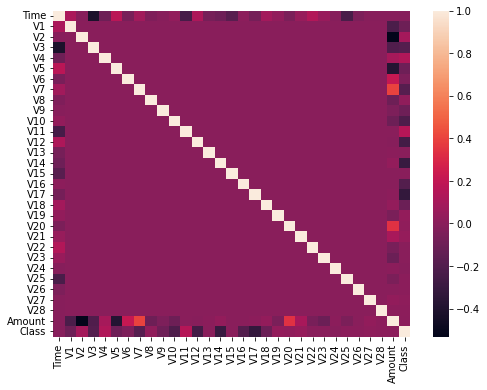

In [14]:
fig, ax = plt.subplots(figsize=(8, 6))
ax = sns.heatmap(df.corr())

## Train and Testset Creation
***
Before balancing the data, I will be splitting it into a training set and a testing set. The test set should come from the original distribution, so we use train_test_split and stratify based on the class distribution.
- The output shows that our distributions are the same. We have less than 100 positive samples in the test set, but this should still be enough to get a gauge of how well the model performs later. 


**holdout_df** will contain the test samples and will not be touched outside model evaluation later.

In [15]:
from sklearn.model_selection import train_test_split

X = df.drop(labels=['Class'], axis=1)
y = df['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y)

train_df = pd.concat([X_train, y_train], axis=1)
holdout_df = pd.concat([X_test, y_test], axis=1)

print('TRAINING SET')
print('- Fraud class size: {}\n- Non-Fraud class size: {}'.format(len(train_df[train_df.Class == 1]), len(train_df[train_df.Class == 0])))
class_distribution(train_df)

print('TESTING SET')
print('- Fraud class size: {}\n- Non-Fraud class size: {}'.format(len(holdout_df[holdout_df.Class == 1]), len(holdout_df[holdout_df.Class == 0])))
class_distribution(holdout_df)

TRAINING SET
- Fraud class size: 394
- Non-Fraud class size: 227451
% dataset with class 0: 99.83%
% dataset with class 1: 0.17%

TESTING SET
- Fraud class size: 98
- Non-Fraud class size: 56864
% dataset with class 0: 99.83%
% dataset with class 1: 0.17%



## Random Undersampling
***
The main technique employed here, we simply select an equal number of non-fraud samples as we do fraud samples. 

Performing random undersampling! Just randomly choose equal portion non-fraud samples and fraud samples. Since there are more non-fraud samples, we only have to portion down this field, and we keep all the fraud-samples.

In [16]:
new_df = train_df.groupby('Class', group_keys=False).apply(lambda x: x.sample(len(train_df[train_df.Class == 1])))
print(len(new_df))

788


### EDA - Random Undersampling

The Count plot shows that our dataset is now evenly distributed with less than 800 samples remaining.

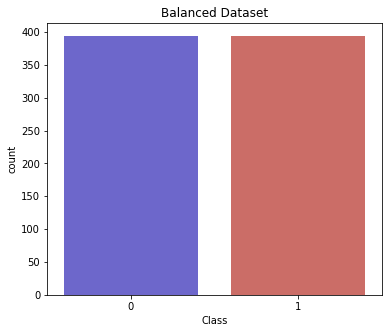

In [17]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(x='Class', data=new_df, palette=cmap)
plt.title('Balanced Dataset')
plt.show()

##### Correlation Matrix
***
- Now that the data is balanced, the correlation matrix is showing some useful information!
- When comparing the correlations of {V1,...,V28} to the Class (Fraudulent or Non-Fraudulent), we notice that features V1-V18 appear to have the strongest correlations.
    - I expect these will be helpful predictors for the model later on.
- Features like V21 and V22 are strongly correlated, neither seems to be correlated to the Class in any particular way, so this information alone may not be directly useful for predicting the class. 
- I will focus visualizations on the features which have a decent correlation with the Class
    - correlation $\geq 0.6$:
    - The specific intervals can be modified to consider more or less features.
***
The code I wrote allows for more modular data exploration, allowing for more or less features to be considered from trimming and analysis depending on the values chosen. Feel free to change these values to see how other features correlate to the class and remove outliers from them as well!

Correlation matrix on balanced data. Features with strong correlation with Class are selected for further exploration.

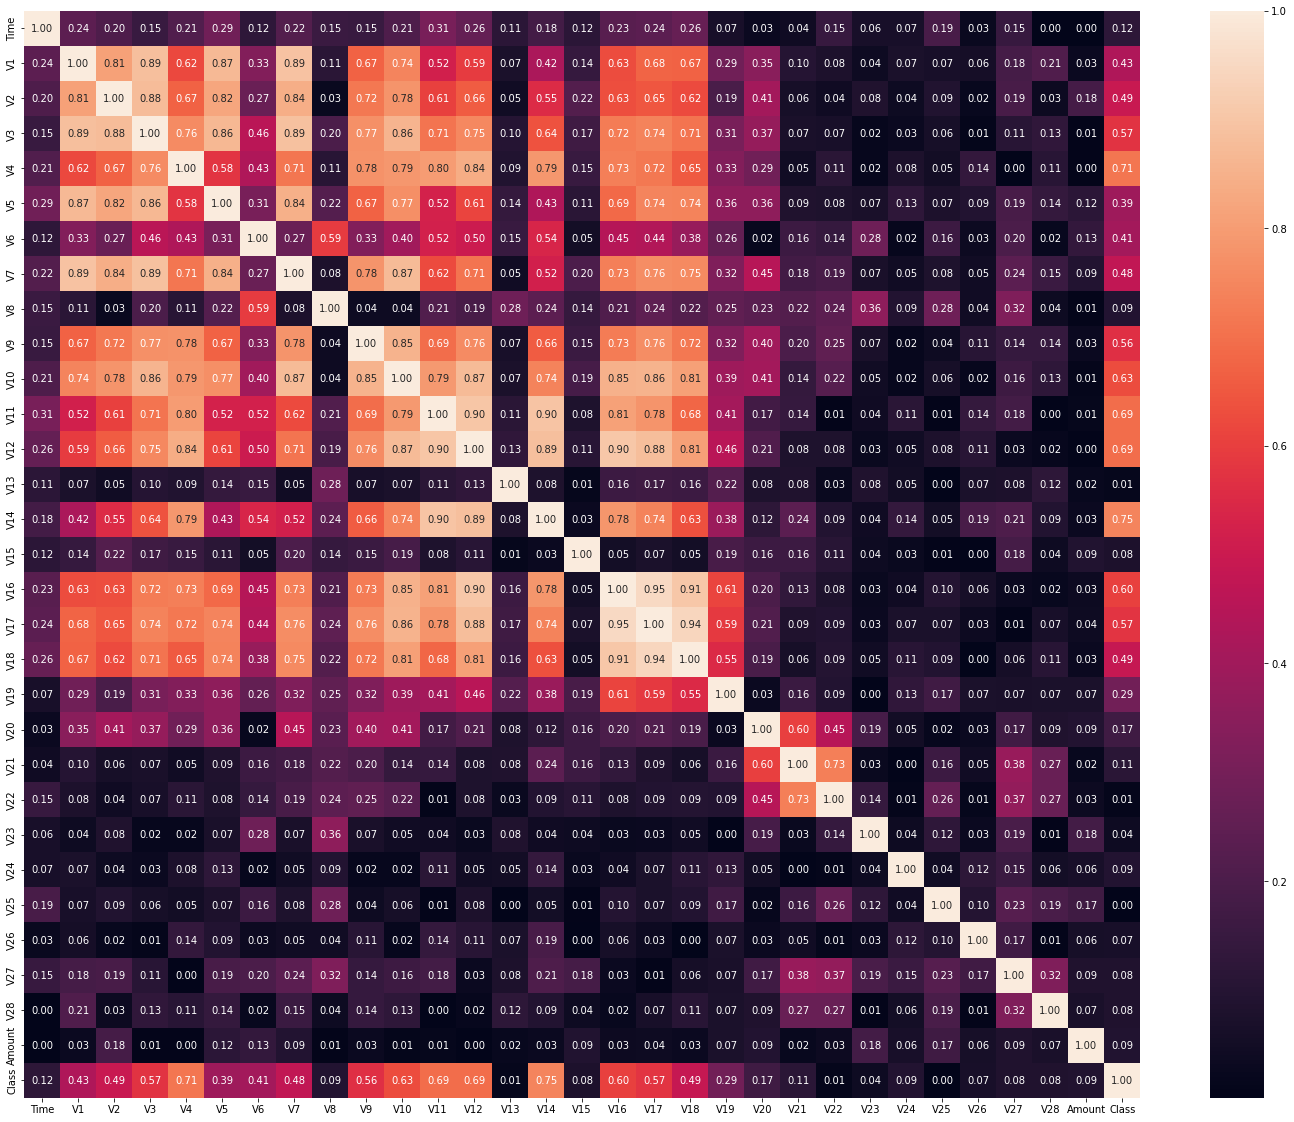

In [18]:
corr = abs(new_df.corr())

fig, ax = plt.subplots(figsize=(25, 20))
ax = sns.heatmap(corr, annot=True, fmt=".2f")

##### We can see some features with very high correlations
- Some of them may be removed if we want to reduce the dimensionality further.
- I will be testing model performance with and without some of these.
- From here, it looks like:
    - $V11 \sim V12 \sim V14$
    - $V12 \sim V16$
    - $V16 \sim V17 \sim V18$ 
    - where A ~ B reads A is strongly correlated to B.
    - Keeping $V11, V12, V16$ should preserve most of the information from the 6 of them. 

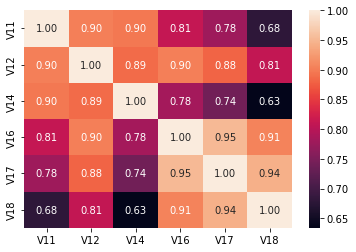

In [19]:
new_corr = abs(new_df[['V11', 'V12', 'V14', 'V16', 'V17', 'V18']].corr())
sns.heatmap(new_corr, annot=True, fmt='.2f')
plt.show()

##### Here I define some helper functions to add attributes to our dataframe
- Class Name: Used for identifying classes of examples.
- Class Dist: Used for plotting, a distribution with variance > 0 is needed for the plots we use!

In [20]:
def create_class_names(df, col='Class Name'):
    df.loc[df['Class'] == 1, col] = 'Fraud'
    df.loc[df['Class'] == 0, col] = 'Non-Fraud'
    
    return df

def create_class_distribution(df, col='Class Dist'):
    zero_class_dist = np.random.normal(loc=0, scale=0.1, size=len(df.loc[df['Class'] == 0]))
    one_class_dist = np.random.normal(loc=1, scale=0.1, size=len(df.loc[df['Class'] == 1]))

    df.loc[df['Class'] == 0, col] = zero_class_dist
    df.loc[df['Class'] == 1, col] = one_class_dist
    
    return df

new_df = create_class_names(new_df)
new_df = create_class_distribution(new_df)

##### Now we define a function to get and display the featurs with a correlation with the class of $\geq$ 0.6
- This will be used for statistical purposes. We want to display plots for a relatively small subset of the highest correlated features.
- The correlation here is strictly with Class.

In [21]:
def get_high_corr_feats(df, min_val, excluded_feats=['Class', 'Class Name', 'Class Dist'], summary=True):
    class_corr = abs(df.corr()['Class'])
    # don't include class for this (1 correlation with itself)
    corr_feats = class_corr.loc[(class_corr >= min_val) & (~class_corr.index.isin(excluded_feats))]
    
    if summary:
        print('Features Strongly Correlated with Class')
        for idx in corr_feats.index:
            print(idx, corr_feats[idx])

    return corr_feats

We have 5 features to plot.

In [22]:
corr_feats = get_high_corr_feats(new_df, min_val=0.69)

Features Strongly Correlated with Class
V4 0.712851174754311
V11 0.6924093753022605
V12 0.6938862292981489
V14 0.7459914438733998


##### Joint Distribution
***
This plot is why we added the **Class Dist** attribute earlier. To plot the joint distribution, the kdeplot needs a variable with a non-trivial standard deviation. By creating a variable which approximates the distribution of class labels, 0 and 1, with a very small variance, we can see the relative distributions in an intuitive way. 
- This is similar to a boxplot but for the purposes of this project, I chose to visualize it this way as I find it more beautiful. 
- Box-plot would likely be easier to work with and better for having a direct comparison of the distributions (box plot can work with integer class labels).

In [23]:
def plot_joint_distribution(df, corr_feats, x_label='Class Dist', hue='Class Name'):
    fig, axs = plt.subplots(1, len(corr_feats), figsize=(20, 5))
    for i, feat in enumerate(corr_feats.index):
        sns.kdeplot(data=df, x=x_label, y=feat, ax=axs[i], hue=hue, palette=cmap)
        axs[i].set_title('{} vs. Class Distribution - Correlation: {}'.format(feat, round(corr_feats[feat], 3)))
        plt.suptitle('Joint Distribution of Features and Class\nPositive Correlation with Class')

    plt.tight_layout(w_pad=10.0)
    plt.show()

V4 and V11 seem to be positively correlated with class while the rest are negatively correlated.
- The type of correlation is not relevant since we don't know what any of the features are. Taking the absolute value allows us to find the most correlated features indiscriminantly.

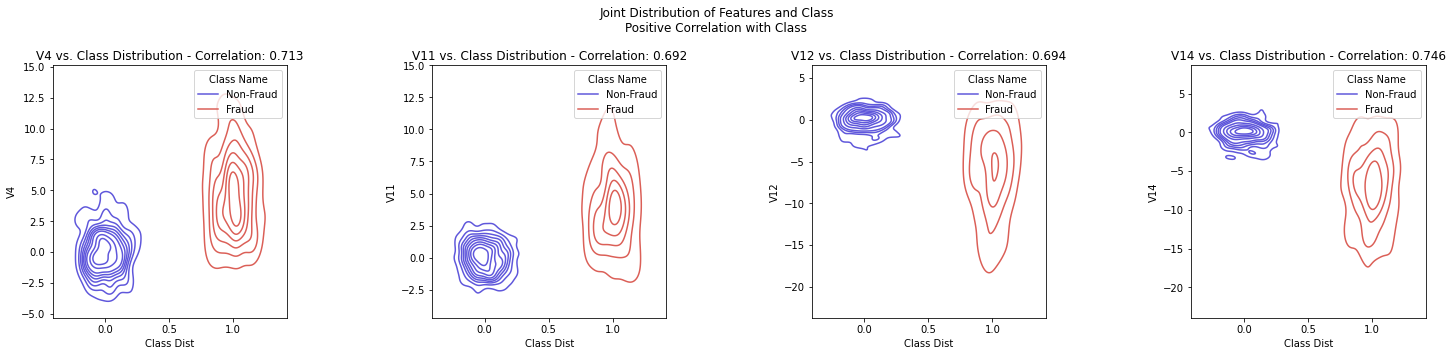

In [24]:
plot_joint_distribution(new_df, corr_feats)

##### Histograms of the number of transactions over time and amount
We find the same circadian cycle for transactions over time.
- We don't expect this to change much since we randomly sampled the dataset. 
- This just has less points to use to plot the distribution.

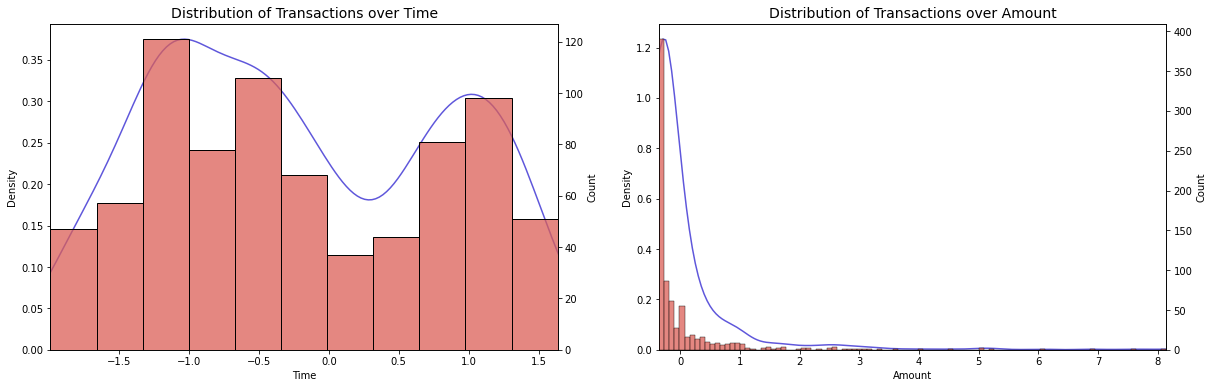

In [25]:
amount_time_distributions(new_df)

#### Removing Outliers
***
It is important for the training data to capture the general distribution of the data as best as possible. One way to do this is by removing examples that are extreme (outliers) from the training set. We can do this by capturing the interquartile range of the data along particular attributes, and using a threshold to apply a bounded filter to the data. 
- This will remove all the datapoints that fall outside some inner-range of the data's distribution. 
- The threshold we use is 1.5, giving bounds:
    - lower_bound = lower_quartile - threshold * interquartile_range
    - upper_bound = upper_quartile + threshold * interquartile_range

In [26]:
def get_irq_from_dataframe(df):
    lower_quartile = df.quantile(0.25)
    upper_quartile = df.quantile(0.75)
    return upper_quartile - lower_quartile, lower_quartile, upper_quartile

def trim_outliers(df, irq, lower_quartile, upper_quartile, slice, threshold=1.5):
    lower_bound = lower_quartile - threshold * irq
    upper_bound = upper_quartile + threshold * irq

    outlier_indices = slice[(slice > upper_bound) | (slice < lower_bound)].index
    
    df = df.drop(outlier_indices)

    return df, lower_bound, upper_bound

def show_outliers(slice, lower_bound, upper_bound):
    outlier_indices = slice[(slice > upper_bound) | (slice < lower_bound)].index
    noutliers = len(outlier_indices)
    
    outliers = [x for x in slice[outlier_indices]]
    
    print('{} # outliers: {}'.format(slice.name, noutliers))
    print('{} outliers: {}'.format(slice.name, outliers))
    
def trim_feature_outliers(df, feats, threshold=1.5, summary=True):
    trimmed_df = df.copy()

    for feat in feats:
        feat_fraud = trimmed_df[feat].loc[trimmed_df['Class'] == 1]
        irq, lower_quartile, upper_quartile = get_irq_from_dataframe(feat_fraud)
        
        if summary:
            print(f'FEATURE {feat}:')
            print('Dataset size (pre-trim): ', len(trimmed_df))
            print('\nInterquartile Range: {}\nQuartiles: {}\n'.format(irq, [lower_quartile, upper_quartile]))
            
        trimmed_df, lower_bound, upper_bound = trim_outliers(trimmed_df, irq, lower_quartile, upper_quartile, slice=feat_fraud, threshold=threshold)
        show_outliers(feat_fraud, lower_bound, upper_bound)
        
        if summary:
            print('Bounds: {}\n'.format([lower_bound, upper_bound]))
            print('Dataset size (post-trim): ', len(trimmed_df))
            print('---'*45)
    
    return trimmed_df

def plot_outliers_removed(df, feats, corr_label='Positively'):
    fig, axs = plt.subplots(1, len(feats), figsize=(5*len(feats),5))
    
    for i, feat in enumerate(feats.index):
        sns.boxplot(x="Class", y=feat, data=df, ax=axs[i], palette=cmap)
        axs[i].set_title(f"{feat} Feature Distribution\nOutliers Removed", fontsize=14)
        axs[i].legend(handles=[nonfraud_patch, fraud_patch])
        
    plt.suptitle(f'Features {corr_label} Correlated with Class', fontsize=16)
    plt.tight_layout(w_pad=5.0)
    plt.show()

The resulting dataframe (with less outliers), is stored into trimmed_df
- The output shows the features we remove outliers from. 
- For each feature in **feats** we capture the distribution of that feature across the dataset, **new_df**.

In [27]:
feats = corr_feats.index
# feats = [feat for feat in new_df.columns if feat not in ['Class', 'Class Dist', 'Class Name', 'Time', 'Amount']]
trimmed_df = trim_feature_outliers(new_df, feats=feats, threshold=1.4, summary=True)

FEATURE V4:
Dataset size (pre-trim):  788

Interquartile Range: 4.0126815680666645
Quartiles: [2.427622419722775, 6.44030398778944]

V4 # outliers: 0
V4 outliers: []
Bounds: [-3.1901317755705545, 12.05805818308277]

Dataset size (post-trim):  788
---------------------------------------------------------------------------------------------------------------------------------------
FEATURE V11:
Dataset size (pre-trim):  788

Interquartile Range: 3.472541153133987
Quartiles: [1.999688996162245, 5.472230149296232]

V11 # outliers: 9
V11 outliers: [10.8530116481991, 11.2779207278067, 11.228470279576, 11.6692047358121, 10.5452629545898, 12.0189131816199, 11.1524905985837, 10.446846814514, 11.0270590938161]
Bounds: [-2.861868618225336, 10.333787763683812]

Dataset size (post-trim):  779
---------------------------------------------------------------------------------------------------------------------------------------
FEATURE V12:
Dataset size (pre-trim):  779

Interquartile Range: 5.807971

With the outliers removed for the given features, we can now visualize the new distributions with boxplots.
- We apply outlier removal to the 'Fraud' class. 
- This can be contrasted with the 'Non-Fraud' class which did not have any outliers removed.
    - There are far less outliers in the Fraud plot than the Non-Fraud.

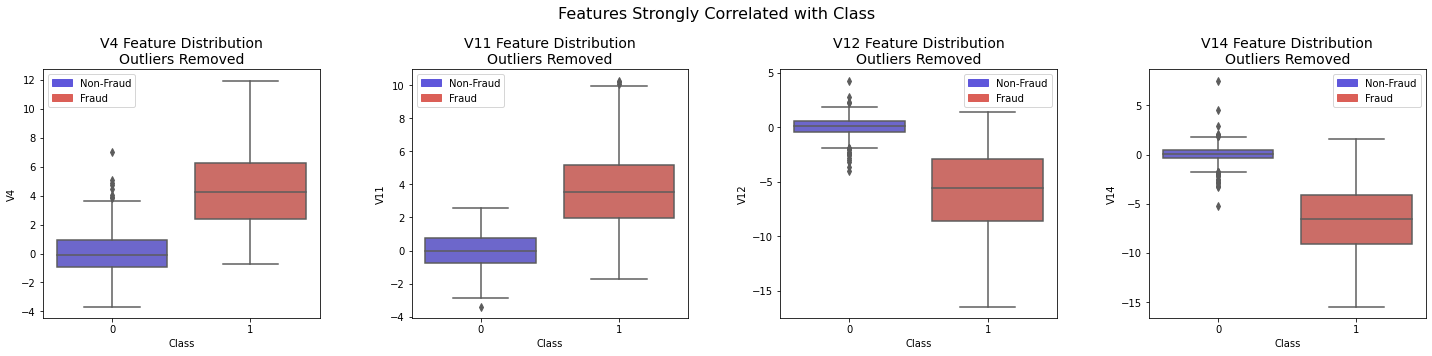

In [28]:
plot_outliers_removed(trimmed_df, corr_feats, corr_label='Strongly')

#### Dimensionality Reduction

By reducing dimensionality, we can look for signs of clustering inherent to the data.
- The data we have processed so far will be reduced to 2-dimensions and plotted. 
- The points will be colored with respect to their class.

In [29]:
def plot_reduced_dimensions(df, method='tsne'):
    fig, ax = plt.subplots(1, 1, figsize=(8, 5))
    fig.suptitle('Dimensionality Reduction Clustering Visualization')

    X = df.drop(['Class', 'Class Name', 'Class Dist'], axis=1)
    y = df['Class']

    if method == 'tsne':
        X_tsne = TSNE(n_components=2, init='pca', learning_rate='auto', perplexity=40).fit_transform(X)
        ax.scatter(X_tsne[:, 0], X_tsne[:,1], c=(y == 0), cmap='coolwarm', label='Non-Fraud')
        ax.scatter(X_tsne[:, 0], X_tsne[:,1], c=(y == 1), cmap='coolwarm', label='Fraud')
        ax.set_title('t-SNE')
        ax.legend(handles=[nonfraud_patch, fraud_patch])
        plt.show()
        
        return X_tsne
    
    elif method == 'pca':
        X_pca = PCA(n_components=2).fit_transform(X)
        ax.scatter(X_pca[:, 0], X_pca[:,1], c=(y == 0), cmap='coolwarm', label='Non-Fraud')
        ax.scatter(X_pca[:, 0], X_pca[:,1], c=(y == 1), cmap='coolwarm', label='Fraud')
        ax.set_title('PCA')
        ax.legend(handles=[nonfraud_patch, fraud_patch])
        
        return X_pca
    
    else:
        print('Error: Invalid dimensionality reduction method. Please choose a method from ["tsne", "pca"].')
    
    return None

##### t-SNE shows clear clustering with respect to class.
- The classes seem reasonably separated about x = 5. 
- There is some ambiguity, but this is bound to happen when we reduce the dimensionality so much.
##### PCA shows relatively good clustering. The boundary is not as clear as in t-SNE.
- Non-Fraud samples are tighly grouped along the principle components.
- Fraud samples have a wider range of values, but tend to hover left of the non-fraud cluster. 
- The ambiguity is greater here, but at least it appears the data is mostly separable.

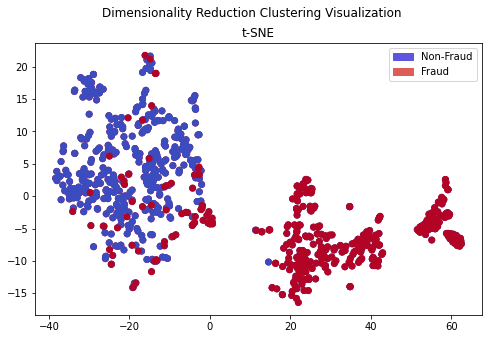

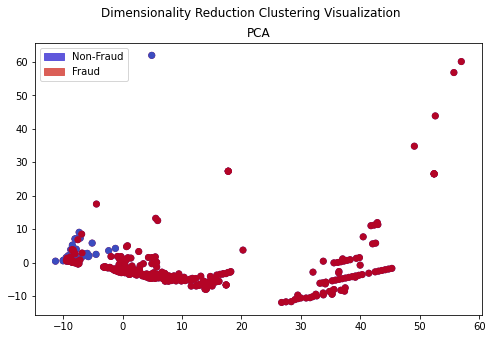

In [30]:
X_tsne = plot_reduced_dimensions(trimmed_df, method='tsne')
X_pca = plot_reduced_dimensions(trimmed_df, method='pca')

## Model Selection and Training
***
It is important to test simple and effective models on this data to get an idea of how good the data is, and establish some baseline performance. 
- RandomForestClassifer. We may choose to use this for future feature engineering as we can get feature importance inherent to the class. 
- LogisticRegression. This classifier will find the best decision boundary separating the data according the a probability that it belongs to a given class.
- SVM. This will simply find the decision boundary that maximizes the margin from data points to the hyperplane separating them.

##### Imports and Helper Functions

In [31]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix
from sklearn.metrics import roc_curve

In [32]:
def evaluate_rfc_crossval(model, X, y, cv=5):
    """
    Evaluates a RandomForestClassifier using cross-validation and returns the average accuracy score.
    
    Parameters:
    - X: The input features as a 2D array or DataFrame.
    - y: The target variable as a 1D array or Series.
    - cv: The number of cross-validation folds (default: 5).
    
    Returns:
    - The average accuracy score across the cross-validation folds.
    """
    
    scoring = {'accuracy': 'accuracy', 'precision': 'precision', 'recall': 'recall', 'roc_auc': 'roc_auc'}
    
    # Perform cross-validation and compute the scores
    scores = cross_validate(model, X, y, scoring=scoring, cv=cv)

    avg_accuracy = scores['test_accuracy'].mean()
    avg_precision = scores['test_precision'].mean()
    avg_recall = scores['test_recall'].mean()
    avg_roc_auc = scores['test_roc_auc'].mean()
    
    # Return the average accuracy score
    return {'accuracy': avg_accuracy, 'precision': avg_precision, 'recall': avg_recall, 'roc_auc': avg_roc_auc}

def evaluate_model(model, X, y, label='Random Forest', show_cm=True):
    y_pred = model.predict(X)
    
    acc, precision, recall, roc = accuracy_score(y, y_pred), precision_score(y, y_pred), recall_score(y, y_pred), roc_auc_score(y, y_pred)

    scores = [acc, precision, recall, roc]
    scores = [round(score, 4) for score in scores]
    scores_df = pd.DataFrame([scores], columns=['Accuracy', 'Precision', 'Recall', 'AUC-ROC'])

    if show_cm:
        _confusion_matrix = plot_confusion_matrix(y, y_pred, label=label)
    else:
        _confusion_matrix = confusion_matrix(y, y_pred)
    
    # Return the average accuracy score
    return scores_df, _confusion_matrix

def plot_confusion_matrix(y_true, y_pred, label='Random Forest'):
    _confusion_matrix = confusion_matrix(y_true, y_pred)

    # Maps the confusion matrix so each row is a distribution for that row. Easier to visualize.
    # confusion_matrix_ = confusion_matrix_.astype('float') / confusion_matrix_.sum(axis=1).reshape(2, 1)

    sns.heatmap(_confusion_matrix, annot=True)
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    plt.title(f'Confusion Matrix - {label}')
    plt.show()
    
    return _confusion_matrix

def get_splits_from_dataframe(df, drop_cols=['Class', 'Class Name', 'Class Dist'], label='Class', test_size=0.2, random_state=42):
    X = df.drop(drop_cols, 1)
    y = df[label]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train, y_test

def train_and_evaluate_model(model, data, drop_cols=['Class', 'Class Name', 'Class Dist'], label='Logistic Regression', show_cm=True):
    X_train, X_test, y_train, y_test = get_splits_from_dataframe(data, drop_cols=drop_cols)
    model.fit(X_train, y_train)
    scores, _confusion_matrix = evaluate_model(model, X_test, y_test, label=label, show_cm=show_cm)
    return scores, _confusion_matrix

def train_and_evaluate_models(models, data, drop_cols=['Class', 'Class Name', 'Class Dist']):
    fig, axs = plt.subplots(1, len(models), figsize=(20, 5))
    scores = []
    for i, name in enumerate(models):
        model = models[name]
        
        score_df, _confusion_matrix = train_and_evaluate_model(model, data, label=name, show_cm=False, drop_cols=drop_cols)
        score_df.insert(0, 'Model', name)
        scores.append(score_df)

        sns.heatmap(_confusion_matrix, ax=axs[i], annot=True)
        axs[i].set_xlabel('Predicted label')
        axs[i].set_ylabel('True label')
        axs[i].set_title(f'Confusion Matrix - {name}')
    
    plt.suptitle('Confusion Matrix by Model')
    plt.show()
        
    scores_df = pd.concat(scores)
    
    return scores_df

##### Model Initialization
- We define our models here and add them to a dictionary so we can easily compare results.
- These parameters are all optional, feel free to change them to see how they affect the performance.
- The confusion matrix is calculated on the test set derived from the training set. 
- Results on the entire holdout set we split earlier in the project are difficult to interpret this way since the class imbalance is so large and there are so many samples. 
    - The performance of the model on the holdout set is best visualized through an ROC plot.

In [33]:
def create_models():
    rfc = RandomForestClassifier(
        n_estimators=500,
        min_samples_split=0.02,
        min_samples_leaf=1, 
        class_weight='balanced', 
        max_features='sqrt'
    )

    lr = LogisticRegression(
        class_weight='balanced', 
        solver='liblinear',
        multi_class='ovr'
    )

    svc = SVC(
        C = 5.0,
        class_weight='balanced', 
        probability=True
    )

    return {'Random Forest': rfc, 'Logistic Regression': lr, 'Support Vector Classifier': svc}

#### Model Training and Evaluation

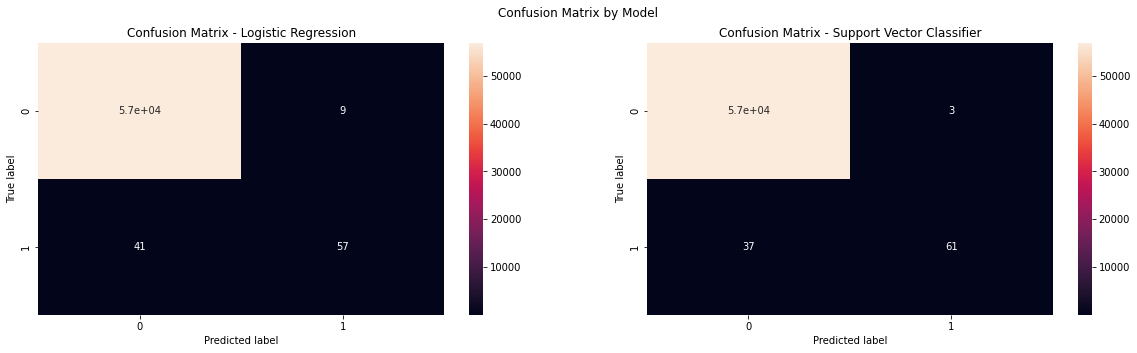

Model,Accuracy,Precision,Recall,AUC-ROC
Logistic Regression,0.9991,0.8636,0.5816,0.7907
Support Vector Classifier,0.9993,0.9531,0.6224,0.8112


In [35]:
models = {'Logistic Regression': LogisticRegression(), 'Support Vector Classifier': SVC()}
scores = train_and_evaluate_models(models, data=df, drop_cols=['Class'])
HTML(scores.to_html(index=False))

Based on our test set (model was not fit on these samples), we can see that the model is making very good predictions all around. The model tends to classify some fraud examples as non-fraud, but the degree to which this occurs is very low. 
- We are achieving over .97 precision and 0.85 recall for each model!
- High precision is good for this problem since we don't want the model flagging everything as fraudulent (potentially cancelling valid transactions if we were to integrate this model into a bank system).
    - If the precision is high and the recall is low, we will miss a lot of fraudulent transactions. 
    - Therefore, a balance between precision and recall is necessary. 
- The recall scores are still fairly high so the models are performing well.

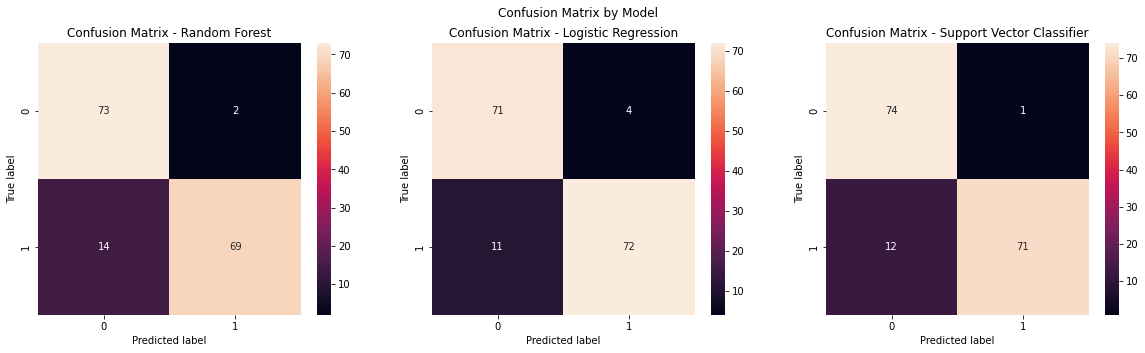

Model,Accuracy,Precision,Recall,AUC-ROC
Random Forest,0.8987,0.9718,0.8313,0.9023
Logistic Regression,0.9051,0.9474,0.8675,0.9071
Support Vector Classifier,0.9177,0.9861,0.8554,0.9210


In [36]:
models = create_models()
scores = train_and_evaluate_models(models, data=new_df)
HTML(scores.to_html(index=False))

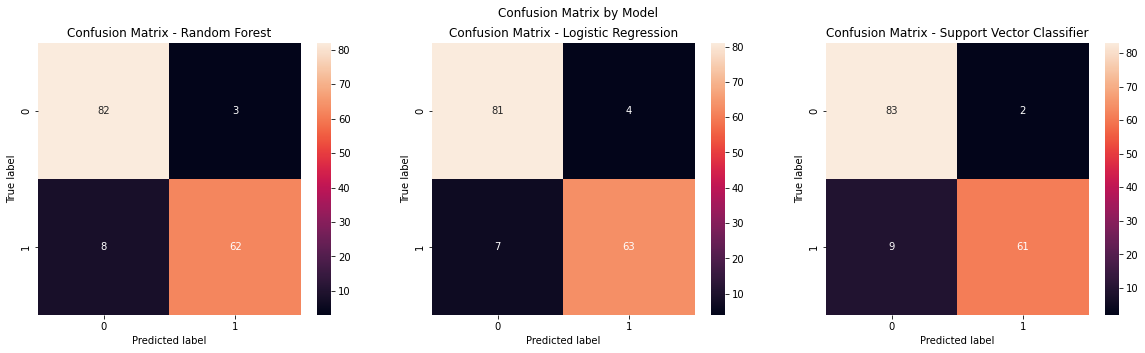

Model,Accuracy,Precision,Recall,AUC-ROC
Random Forest,0.929,0.9538,0.8857,0.9252
Logistic Regression,0.929,0.9403,0.9000,0.9265
Support Vector Classifier,0.929,0.9683,0.8714,0.9239


In [37]:
models = create_models()
scores = train_and_evaluate_models(models, data=trimmed_df)
HTML(scores.to_html(index=False))

##### ROC Curves
***
To see how the model performs on the original holdout set (+50k examples with high class imbalance)

In [38]:
def plot_roc_curves(curves):
    def plot_roc_curve(fpr, tpr, label=None, color='b'):
        plt.plot(fpr, tpr, label=label, color=color)
    
    plt.figure(figsize=(15, 10))
    plt.title(f'ROC Curve for Classifiers')
    plt.plot([0, 1], [0, 1], 'r--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.axis([-.05, 1, 0, 1.05])
    
    palette = sns.color_palette('hls', 8)
        
    for i, name in enumerate(curves):
        fpr, tpr, _ = curves[name]
        plot_roc_curve(fpr, tpr, label=name, color=palette[(i+1)*2])
    
    plt.legend()
    plt.show()
        

def get_roc_curves(models, X, y):
    curves = {}
    
    for name in models:
        y_pred_proba = models[name].predict_proba(X)
        fpr, tpr, threshold = roc_curve(y, y_pred_proba[:, 1])
        
        curves[name] = (fpr, tpr, threshold)
    
    return curves

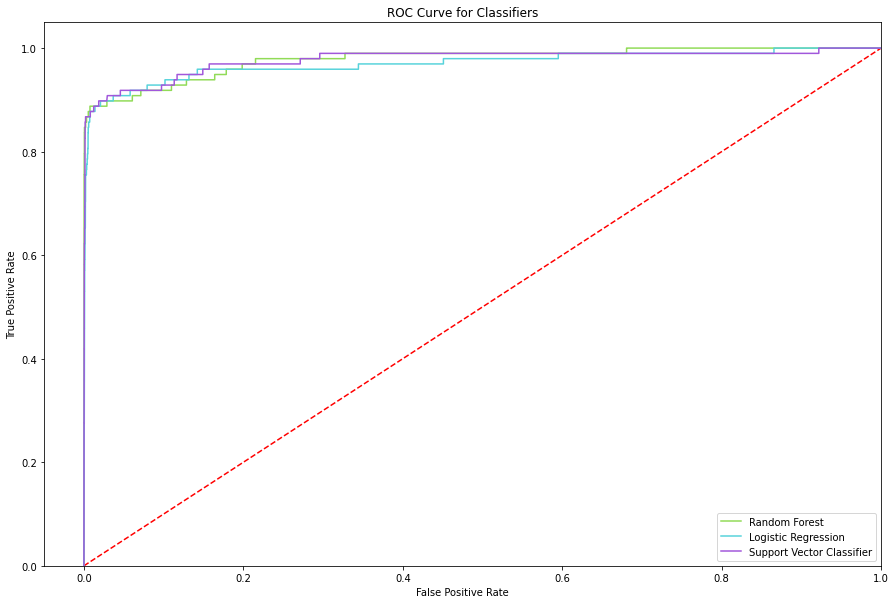

In [39]:
roc_curves = get_roc_curves(models, X_test, y_test)
plot_roc_curves(roc_curves)

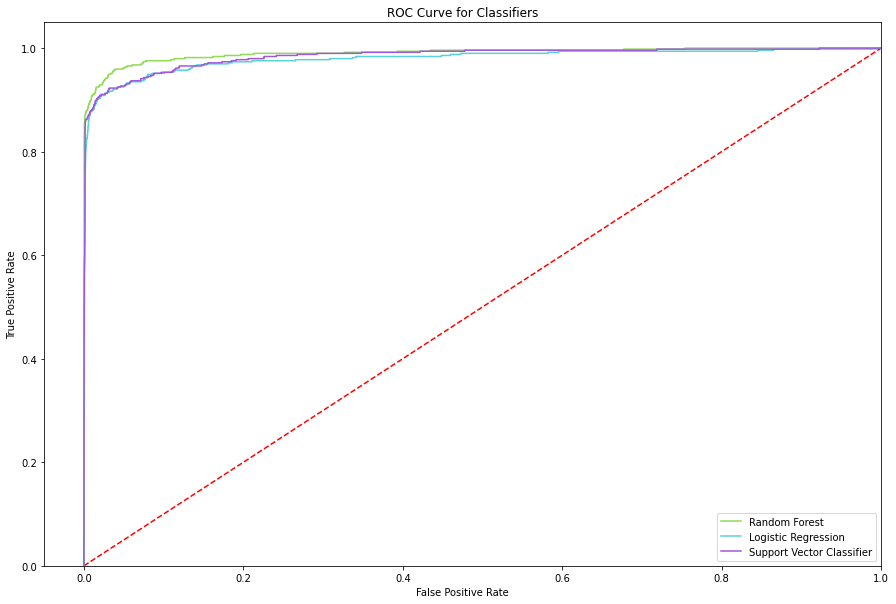

In [40]:
# cols = ['Class', 'Class Dist', 'Class Name']
cols = ['Class']
X = df.drop(cols, 1)
y = df['Class']
roc_curves = get_roc_curves(models, X, y)
plot_roc_curves(roc_curves)


III. <b>Random UnderSampling and Oversampling</b><br>
a) [Distributing and Correlating](#correlating)<br>


correlating
<a id="correlating"></a>
